In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error

## Load Data

In [2]:
# get data
df = pd.read_csv("Data Science Assignment.csv")
df.head()

,week,product,orders,brand,views,cart_adds,price,inventory
0,12/8/2019,A,41.0,Big Cable Brand,4181.0,209.0,34.99,158
1,12/15/2019,A,36.0,Big Cable Brand,3228.0,114.0,29.99,122
2,12/22/2019,A,51.0,Big Cable Brand,5259.0,108.0,29.99,71
3,12/29/2019,A,38.0,Big Cable Brand,3574.0,50.0,24.99,33
4,1/5/2020,A,33.0,Big Cable Brand,5970.0,66.0,34.99,0


In [3]:
# basic information: null values, data type, etc. 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260 entries, 0 to 259
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   week       260 non-null    object 
 1   product    260 non-null    object 
 2   orders     259 non-null    float64
 3   brand      260 non-null    object 
 4   views      259 non-null    float64
 5   cart_adds  259 non-null    float64
 6   price      259 non-null    float64
 7   inventory  260 non-null    int64  
dtypes: float64(4), int64(1), object(3)
memory usage: 16.4+ KB


In [4]:
# identify null values
np.where(pd.isnull(df))

(array([60, 60, 60, 60]), array([2, 4, 5, 6]))

In [5]:
# fill the null values with interpolate
df = df.interpolate(method='linear', axis=0).bfill()
# df.iloc[60, ]

In [6]:
# basic stats from each column
df.describe()

,orders,views,cart_adds,price,inventory
count,260.000000,260.000000,260.000000,260.000000,260.000000
mean,19.351923,2149.957692,49.982692,70.326538,80.057692
std,14.735643,1951.096732,49.073468,61.503894,49.346859
min,0.000000,39.000000,0.000000,19.990000,0.000000
25%,7.000000,575.000000,16.000000,34.990000,50.750000
50%,16.000000,1447.500000,36.000000,49.990000,70.000000
75%,30.000000,3197.000000,67.000000,84.990000,94.250000
max,100.000000,9138.000000,309.000000,524.990000,308.000000


In [7]:
# check the unique values for each column 
for column in df.columns:
    uniques = sorted(df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(uniques)), uniques[: 5])

week                    52	 ['1/12/2020', '1/19/2020', '1/26/2020', '1/5/2020', '10/11/2020']
product                  5	 ['A', 'B', 'C', 'D', 'E']
orders                  52	 [0.0, 1.0, 2.0, 3.0, 3.5]
brand                    2	 ['Big Cable Brand', 'Little Cable Brand']
views                  250	 [39.0, 84.0, 96.0, 100.0, 101.0]
cart_adds              114	 [0.0, 2.0, 3.0, 4.0, 5.0]
price                   39	 [19.99, 24.99, 29.99, 34.99, 39.99]
inventory              115	 [0, 20, 30, 32, 33]


From the output above, we learnt:  

1. There are five key products; 
2. We only have two kinds of brands 

Since we are only interested in five key products, it might be fine to analyze and make predictions on them seperately (i.e. split the large data set into five smaller sub data sets). If the number of interested key products increases in the future, we will not analyze them seperatly (which will be computationally expensive). Instead, we will keep the column "product" as a feature and one hot encode on them. 

In [8]:
# check the brand for each product
for product, df_product in df.groupby('product'):
    print(df_product['brand'].unique())

['Big Cable Brand']
['Big Cable Brand']
['Little Cable Brand']
['Little Cable Brand']
['Little Cable Brand']


In [9]:
# Since each product only has one brand (not suprisingly), and we are going to split 
#   the data set by products, we will drop this column for now
df = df.drop(['brand'], axis = 1)
df.head()

,week,product,orders,views,cart_adds,price,inventory
0,12/8/2019,A,41.0,4181.0,209.0,34.99,158
1,12/15/2019,A,36.0,3228.0,114.0,29.99,122
2,12/22/2019,A,51.0,5259.0,108.0,29.99,71
3,12/29/2019,A,38.0,3574.0,50.0,24.99,33
4,1/5/2020,A,33.0,5970.0,66.0,34.99,0


In [10]:
# split the data into five subsets
for name in df['product'].unique():
    locals()['df_' + name] = df.loc[df['product'] == name]
    locals()['df_' + name] = locals()['df_' + name].drop(['product'], axis = 1) # drop column
    locals()['df_' + name].week = pd.to_datetime(locals()['df_' + name].week)
    locals()['df_' + name] = locals()['df_' + name].set_index("week") # set "week" as index

In [11]:
# overview of df_A 
df_A.head()

,orders,views,cart_adds,price,inventory
week,,,,,
2019-12-08,41.0,4181.0,209.0,34.99,158
2019-12-15,36.0,3228.0,114.0,29.99,122
2019-12-22,51.0,5259.0,108.0,29.99,71
2019-12-29,38.0,3574.0,50.0,24.99,33
2020-01-05,33.0,5970.0,66.0,34.99,0


## Exploratory Data Analysis

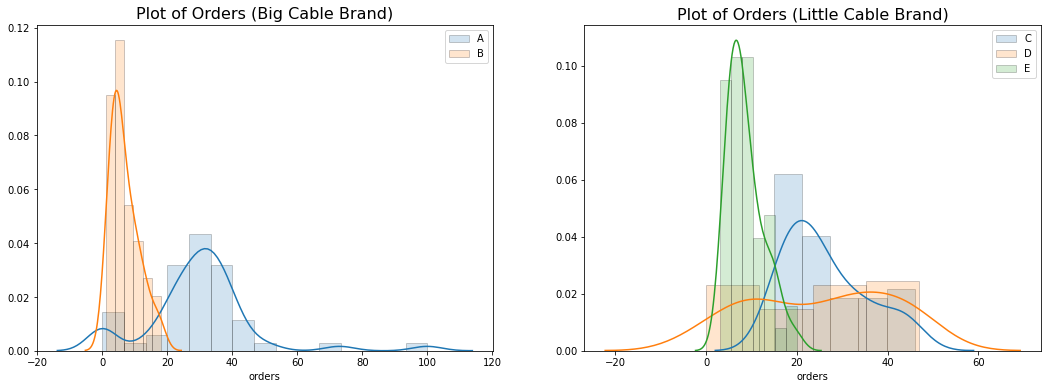

In [12]:
# Visualization of number of orders
hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))

# For products of big cable brand
sns.distplot(df_A['orders'], label = 'A', 
             ax = ax[0], hist_kws = hist_kws)
sns.distplot(df_B['orders'], label = 'B', 
             ax = ax[0], hist_kws = hist_kws)
ax[0].set_title('Plot of Orders (Big Cable Brand)', fontsize=16)
ax[0].legend()

# For products of little cable brand
sns.distplot(df_C['orders'], label = 'C', 
             ax = ax[1], hist_kws = hist_kws)
sns.distplot(df_D['orders'], label = 'D', 
             ax = ax[1], hist_kws = hist_kws)
sns.distplot(df_E['orders'], label = 'E', 
             ax = ax[1], hist_kws = hist_kws)
ax[1].set_title('Plot of Orders (Little Cable Brand)', fontsize=16)
ax[1].legend()
plt.show()

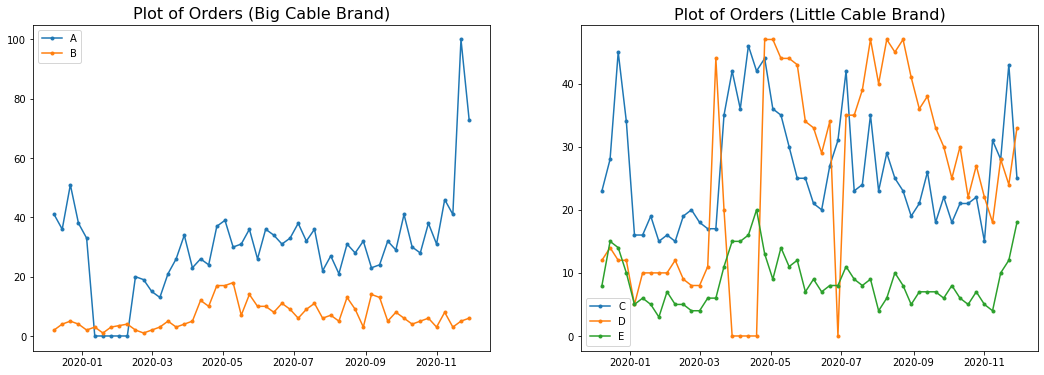

In [13]:
# Visualization of number of orders throughout the years
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
# For products of big cable brand
ax[0].plot(df_A.index, df_A['orders'], '.-', label = 'A')
ax[0].plot(df_B.index, df_B['orders'], '.-', label = 'B')
ax[0].set_title('Plot of Orders (Big Cable Brand)', fontsize=16)
ax[0].legend()
# For products of little cable brand
ax[1].plot(df_C.index, df_C['orders'], '.-', label = 'C')
ax[1].plot(df_D.index, df_D['orders'], '.-', label = 'D')
ax[1].plot(df_E.index, df_E['orders'], '.-', label = 'E')
ax[1].set_title('Plot of Orders (Little Cable Brand)', fontsize=16)
ax[1].legend()

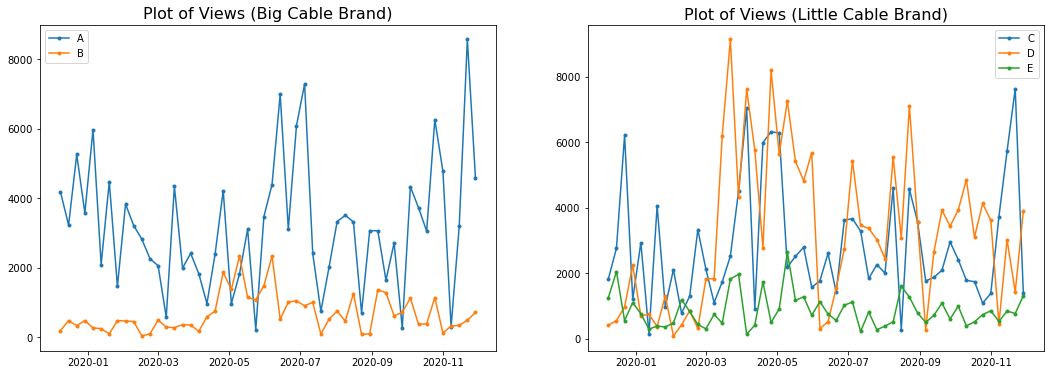

In [14]:
# Visualization of number of views
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
# For products of big cable brand
ax[0].plot(df_A.index, df_A['views'], '.-', label = 'A')
ax[0].plot(df_B.index, df_B['views'], '.-', label = 'B')
ax[0].set_title('Plot of Views (Big Cable Brand)', fontsize=16)
ax[0].legend()
# For products of little cable brand
ax[1].plot(df_C.index, df_C['views'], '.-', label = 'C')
ax[1].plot(df_D.index, df_D['views'], '.-', label = 'D')
ax[1].plot(df_E.index, df_E['views'], '.-', label = 'E')
ax[1].set_title('Plot of Views (Little Cable Brand)', fontsize=16)
ax[1].legend()

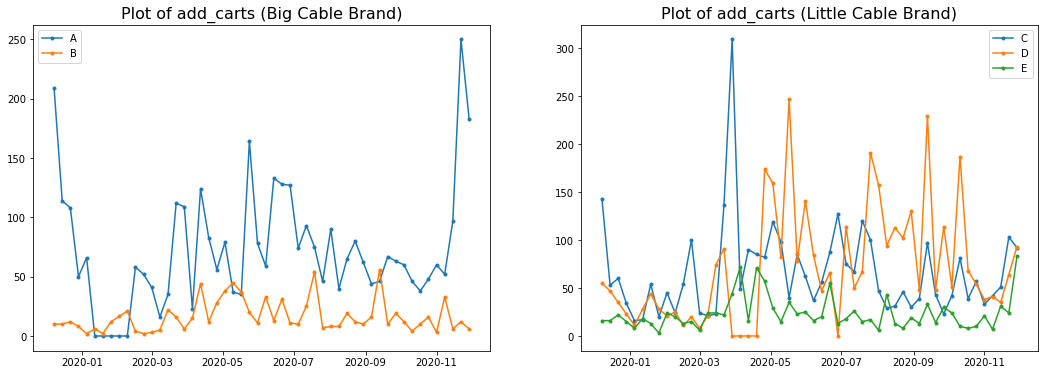

In [15]:
# Visualization of number of cart_adds
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
# For products of big cable brand
ax[0].plot(df_A.index, df_A['cart_adds'], '.-', label = 'A')
ax[0].plot(df_B.index, df_B['cart_adds'], '.-', label = 'B')
ax[0].set_title('Plot of add_carts (Big Cable Brand)', fontsize=16)
ax[0].legend()
# For products of little cable brand
ax[1].plot(df_C.index, df_C['cart_adds'], '.-', label = 'C')
ax[1].plot(df_D.index, df_D['cart_adds'], '.-', label = 'D')
ax[1].plot(df_E.index, df_E['cart_adds'], '.-', label = 'E')
ax[1].set_title('Plot of add_carts (Little Cable Brand)', fontsize=16)
ax[1].legend()

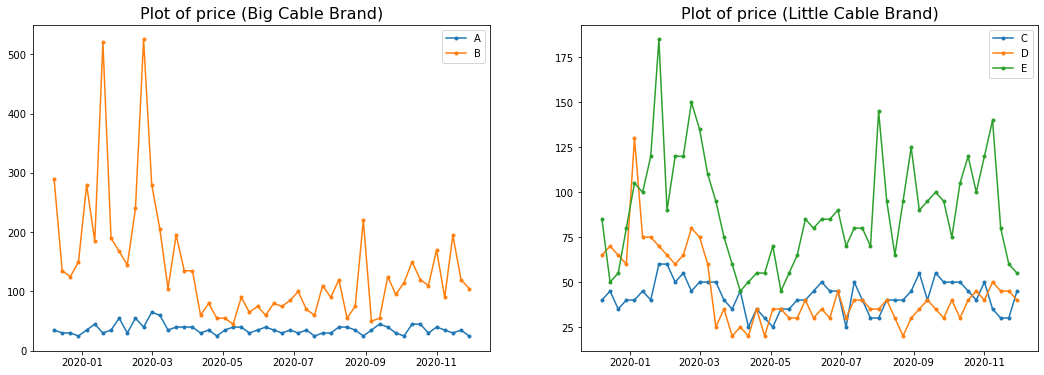

In [16]:
# Visualization of number of price
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
# For products of big cable brand
ax[0].plot(df_A.index, df_A['price'], '.-', label = 'A')
ax[0].plot(df_B.index, df_B['price'], '.-', label = 'B')
ax[0].set_title('Plot of price (Big Cable Brand)', fontsize=16)
ax[0].legend()
# For products of little cable brand
ax[1].plot(df_C.index, df_C['price'], '.-', label = 'C')
ax[1].plot(df_D.index, df_D['price'], '.-', label = 'D')
ax[1].plot(df_E.index, df_E['price'], '.-', label = 'E')
ax[1].set_title('Plot of price (Little Cable Brand)', fontsize=16)
ax[1].legend()

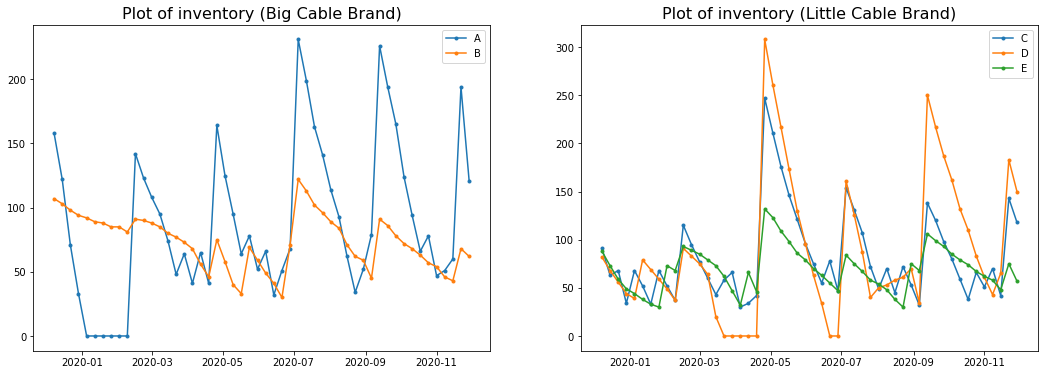

In [17]:
# Visualization of number of inventory
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
# For products of big cable brand
ax[0].plot(df_A.index, df_A['inventory'], '.-', label = 'A')
ax[0].plot(df_B.index, df_B['inventory'], '.-', label = 'B')
ax[0].set_title('Plot of inventory (Big Cable Brand)', fontsize=16)
ax[0].legend()
# For products of little cable brand
ax[1].plot(df_C.index, df_C['inventory'], '.-', label = 'C')
ax[1].plot(df_D.index, df_D['inventory'], '.-', label = 'D')
ax[1].plot(df_E.index, df_E['inventory'], '.-', label = 'E')
ax[1].set_title('Plot of inventory (Little Cable Brand)', fontsize=16)
ax[1].legend()

In [18]:
# further investigate on high orders
df_A.loc[df_A['orders'] > 60]

,orders,views,cart_adds,price,inventory
week,,,,,
2020-11-22,100.0,8564.0,250.0,34.99,194
2020-11-29,73.0,4567.0,183.0,24.99,121


In [19]:
df_E.loc[df_E['orders'] > 15]

,orders,views,cart_adds,price,inventory
week,,,,,
2020-04-12,16.0,412.0,16.0,49.99,66
2020-04-19,20.0,1733.0,71.0,54.99,46
2020-11-29,18.0,1314.0,83.0,54.99,57


In [20]:
# further investigation on zero orders/cart_adds/inventory
df[(df['orders'] == 0) | (df['cart_adds'] == 0) | (df['inventory'] == 0)] 

,week,product,orders,views,cart_adds,price,inventory
4,1/5/2020,A,33.0,5970.0,66.0,34.99,0
5,1/12/2020,A,0.0,2091.0,0.0,44.99,0
6,1/19/2020,A,0.0,4476.0,0.0,29.99,0
7,1/26/2020,A,0.0,1466.0,0.0,34.99,0
8,2/2/2020,A,0.0,3829.0,0.0,54.99,0
9,2/9/2020,A,0.0,3215.0,0.0,29.99,0
171,3/22/2020,D,20.0,9138.0,91.0,34.99,0
172,3/29/2020,D,0.0,4338.0,0.0,19.99,0
173,4/5/2020,D,0.0,7615.0,0.0,24.99,0
174,4/12/2020,D,0.0,5764.0,0.0,19.99,0


In [21]:
# fill zeros with interpolate (they are 0's because we don't have inventory)
df_A.replace(0, np.nan, inplace=True)
df_A = df_A.interpolate(method='linear', axis=0).bfill()
df_D.replace(0, np.nan, inplace=True)
df_D = df_D.interpolate(method='linear', axis=0).bfill()
# df_A
# df_D

## New Variables

In [22]:
lst_of_df = [df_A, df_B, df_C, df_D, df_E]

Since we are working with time series data, it is neccessary to add some features from past
from past using **lag**. Here, we add the order from the past three weeks as new features. We can add more features using **lag** in the future. Now we only lag 'orders'.   
Moreover, we use **lead** to add the **order in the next week** and the **sum of order for the next three weeks**. They are what we want to predict in order to optimize the inventory.

In [23]:
# add lag for the order and add the sum of orders for the next three weeks
for temp_df in lst_of_df:
    temp_df['order_lag_1'] = temp_df['orders'].shift(1)
    temp_df['order_lag_2'] = temp_df['orders'].shift(2)
    temp_df['order_lag_3'] = temp_df['orders'].shift(3)
    temp_df['order_next_week'] = temp_df['orders'].shift(-1)
    temp_df['order_lead_2'] = temp_df['orders'].shift(-2)
    temp_df['order_lead_3'] = temp_df['orders'].shift(-3)
    temp_df['order_in_3weeks'] = temp_df['order_next_week'] + \
                                 temp_df['order_lead_2'] + \
                                 temp_df['order_lead_3']

In [24]:
df_A = df_A[3: ]
df_A = df_A.drop(['inventory', 'order_lead_2', 'order_lead_3'], axis = 1)
df_B = df_B[3: ]
df_B = df_B.drop(['inventory', 'order_lead_2', 'order_lead_3'], axis = 1)
df_C = df_C[3: ]
df_C = df_C.drop(['inventory', 'order_lead_2', 'order_lead_3'], axis = 1)
df_D = df_D[3: ]
df_D = df_D.drop(['inventory', 'order_lead_2', 'order_lead_3'], axis = 1)
df_E = df_E[3: ]
df_E = df_E.drop(['inventory', 'order_lead_2', 'order_lead_3'], axis = 1)
df_A.head()

,orders,views,cart_adds,price,order_lag_1,order_lag_2,order_lag_3,order_next_week,order_in_3weeks
week,,,,,,,,,
2019-12-29,38.000000,3574.0,50.000000,24.99,51.000000,36.000000,41.0,33.000000,92.5
2020-01-05,33.000000,5970.0,66.000000,34.99,38.000000,51.000000,36.0,30.833333,86.0
2020-01-12,30.833333,2091.0,64.666667,44.99,33.000000,38.000000,51.0,28.666667,79.5
2020-01-19,28.666667,4476.0,63.333333,29.99,30.833333,33.000000,38.0,26.500000,73.0
2020-01-26,26.500000,1466.0,62.000000,34.99,28.666667,30.833333,33.0,24.333333,66.5


## Machine Learning: xgboost

This is how we  split the data set:
1. data from 2019-12-29 to 2020-06-07 will be training data
2. data from 2020-06-14 to 2020-09-06 will be validation data
3. data from 2020-09-13 to 2020-11-29 will be test data

In [25]:
split_date_1 = '2020-06-07'
split_date_2 = '2020-06-14'
split_date_3 = '2020-09-06'
split_date_4 = '2020-09-13'

# list of features used
features =  [col for col in df_A.columns if col not in ['order_next_week', 'order_in_3weeks']]

Usually we should spend 1-2 days to fine-tune the model: start with n_estimators 
(with early_stopping_rounds to avoid overfitting), then optimize learning_rate, max_depth, min_child_weight, gamma, etc.    
The model should be selected based on its performance on the validation data set 

In [26]:
# define a function so when we pass a dataframe, it will produce a new dataframe with the
#   prediction on the inventory required in the next week and the next 3 weeks. It will also
#   print the corresponding rmse and mae
def xgb_forecast(df):
    # training data
    X_train = df[features][ : split_date_1]
    y_train_1wk = df['order_next_week'][ : split_date_1]
    y_train_3wk = df['order_in_3weeks'][ : split_date_1]
    
    # validation data
    X_valid = df[features][split_date_2 : split_date_3]
    y_valid_1wk = df['order_next_week'][split_date_2 : split_date_3]
    y_valid_3wk = df['order_in_3weeks'][split_date_2 : split_date_3]
    
    # test data
    X_test = df[features][split_date_4 : ]
    y_test_1wk = df['order_next_week'][split_date_4 : ]
    y_test_3wk = df['order_in_3weeks'][split_date_4 : ]   
    
    # xgboost model 
    early_stop = 10
    
    # predict next week's orders
    reg1 = xgb.XGBRegressor()
    reg1.fit(X_train, y_train_1wk,
            eval_set = [(X_valid, y_valid_1wk)],
            early_stopping_rounds = early_stop, verbose = False)
    X_test['Prediction_next_week'] = reg1.predict(X_test)
    
    # predict next three weeks' orders
    reg2 = xgb.XGBRegressor()
    reg2.fit(X_train, y_train_3wk,
            eval_set = [(X_valid, y_valid_3wk)],
            early_stopping_rounds = early_stop, verbose = False) 
    X_test['Prediction_in_3weeks'] = reg2.predict(X_test[features])    
    final_df = pd.concat([X_test, y_test_1wk, y_test_3wk], axis=1)
    final_df['error_1wk'] = final_df['order_next_week'] - final_df['Prediction_next_week']
    final_df['error_3wk'] = final_df['order_in_3weeks'] - final_df['Prediction_in_3weeks']
    
    # give predictions
    fitted_1wk = final_df['Prediction_next_week'][-1]
    fitted_3wk = final_df['Prediction_in_3weeks'][-1]
    print('we will have : \n {:f} orders for the next week, \n {:f} orders for the following 3 weeks \n'.format(fitted_1wk, fitted_3wk)) 
    
    # find rmse 
    rmse_1wk = np.sqrt(mean_squared_error(y_true = final_df['order_next_week'][ : -1], 
                              y_pred = final_df['Prediction_next_week'][ : -1]))
    rmse_3wk = np.sqrt(mean_squared_error(y_true = final_df['order_in_3weeks'][ : -3], 
                              y_pred = final_df['Prediction_in_3weeks'][ : -3]))

    print('rmse for next week: {:f} \n'.format(rmse_1wk))
    print('rmse for next 3 weeks: {:f} \n'.format(rmse_3wk))
    
    # find mae 
    mae_1wk = mean_absolute_error(y_true = final_df['order_next_week'][ : -1], 
                              y_pred = final_df['Prediction_next_week'][ : -1])
    mae_3wk = mean_absolute_error(y_true = final_df['order_in_3weeks'][ : -3], 
                              y_pred = final_df['Prediction_in_3weeks'][ : -3])
    print('mae for next week: {:f} \n'.format(mae_1wk))
    print('mae for next 3 weeks: {:f} \n'.format(mae_3wk))
    
    # plot feature importances
    plot_importance(reg1, height = 0.9, title = 'feature importance (1 week)')
    plot_importance(reg2, height=0.9, title = 'feature importance (3 weeks)')
    
    # plot residuals
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
    sns.distplot(final_df['error_1wk'], ax = ax[0], hist_kws = hist_kws)
    ax[0].set_title('Residuals (1 week)', fontsize=16)

    sns.distplot(final_df['error_3wk'], ax = ax[1], hist_kws = hist_kws)
    ax[1].set_title('Residuals (3 weeks)', fontsize=16)
    
    # plot fitted values and true values
    fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (18, 6))
    ax[0].plot(final_df.index, final_df['order_next_week'], '.-', label = 'true')
    ax[0].plot(final_df.index, final_df['Prediction_next_week'], '.-', label = 'fitted')
    ax[0].set_title('True order and fitted order (1 week)', fontsize=16)
    ax[0].legend()
    
    ax[1].plot(final_df.index, final_df['order_in_3weeks'], '.-', label = 'true')
    ax[1].plot(final_df.index, final_df['Prediction_in_3weeks'], '.-', label = 'fitted')
    ax[1].set_title('True order and fitted order (3 week)', fontsize=16)
    ax[1].legend()    
    
    
    return final_df

## Model Diagnostics

We would like to know the models' performance on the test data set. We will check the rmse and mae, plot residuals, check the relationship between true value and fitted value. We will also give the prediction for inventory analyst. 

### Product A

we will have : 
 26.631136 orders for the next week, 
 87.591316 orders for the following 3 weeks 

rmse for next week: 26.867448 

rmse for next 3 weeks: 58.641632 

mae for next week: 17.044765 

mae for next 3 weeks: 42.962213 



,orders,views,cart_adds,price,order_lag_1,order_lag_2,order_lag_3,Prediction_next_week,Prediction_in_3weeks,order_next_week,order_in_3weeks,error_1wk,error_3wk
week,,,,,,,,,,,,,
2020-09-13,24.0,1643.0,46.0,44.99,23.0,32.0,28.0,26.373041,83.379234,32.0,102.0,5.626959,18.620766
2020-09-20,32.0,2714.0,67.0,39.99,24.0,23.0,32.0,35.647701,83.061180,29.0,100.0,-6.647701,16.938820
2020-09-27,29.0,267.0,63.0,29.99,32.0,24.0,23.0,29.855215,72.713791,41.0,99.0,11.144785,26.286209
2020-10-04,41.0,4329.0,60.0,24.99,29.0,32.0,24.0,33.342484,78.332008,30.0,96.0,-3.342484,17.667992
2020-10-11,30.0,3726.0,46.0,44.99,41.0,29.0,32.0,34.210476,84.517990,28.0,97.0,-6.210476,12.482010


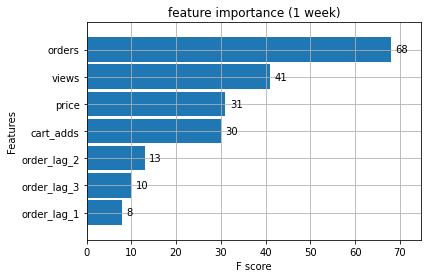

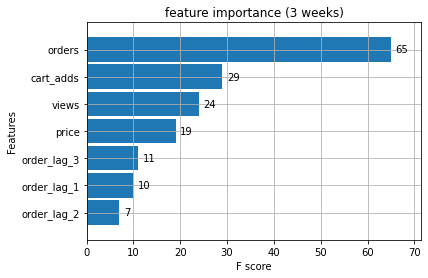

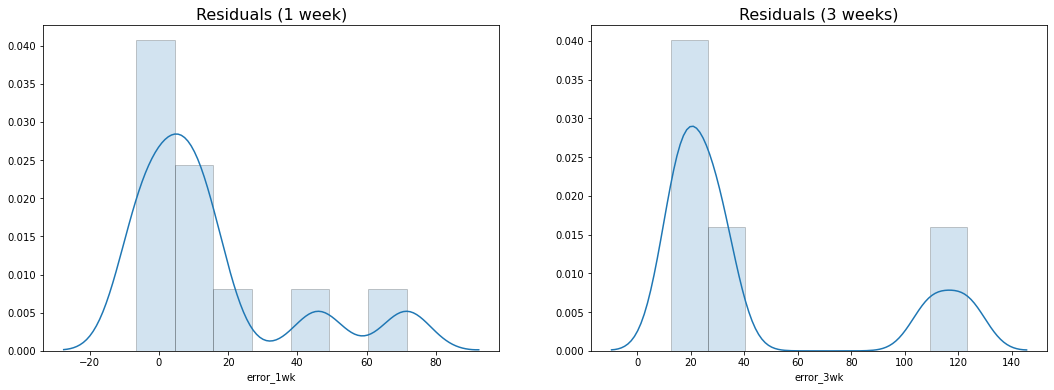

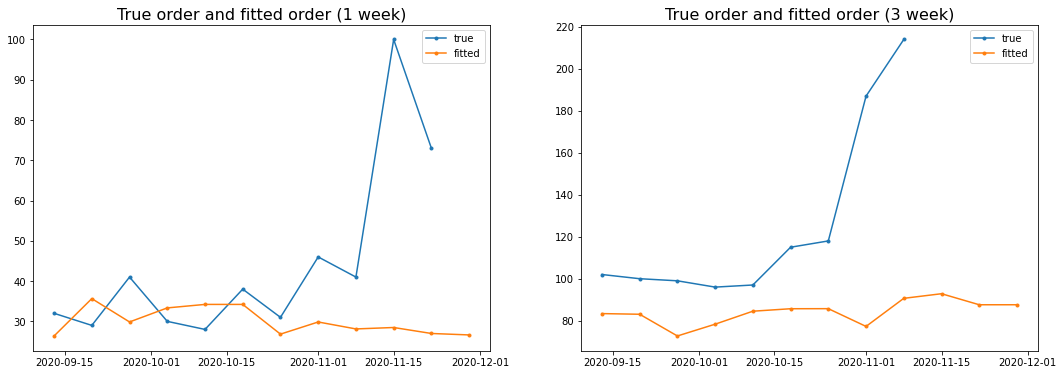

In [27]:
res_A = xgb_forecast(df_A)
res_A.head()

we will have : 
 7.988209 orders for the next week, 
 24.904457 orders for the following 3 weeks 

rmse for next week: 3.774902 

rmse for next 3 weeks: 10.974790 

mae for next week: 3.178607 

mae for next 3 weeks: 10.486403 



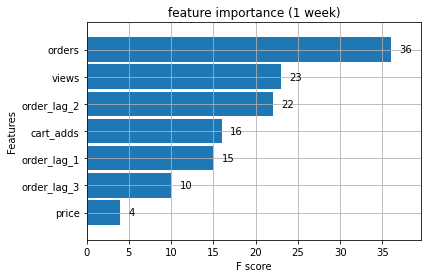

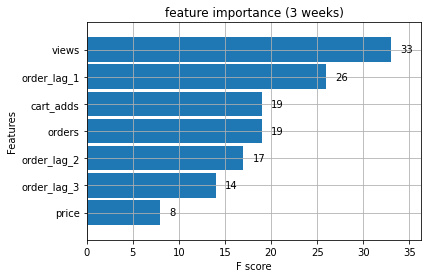

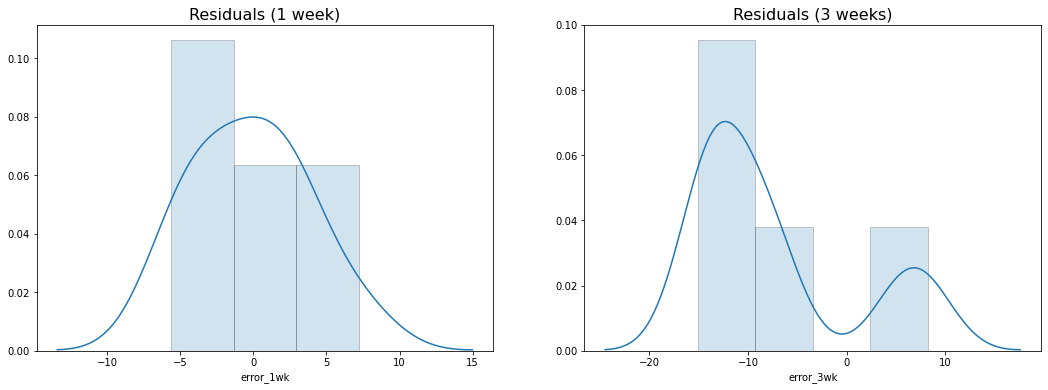

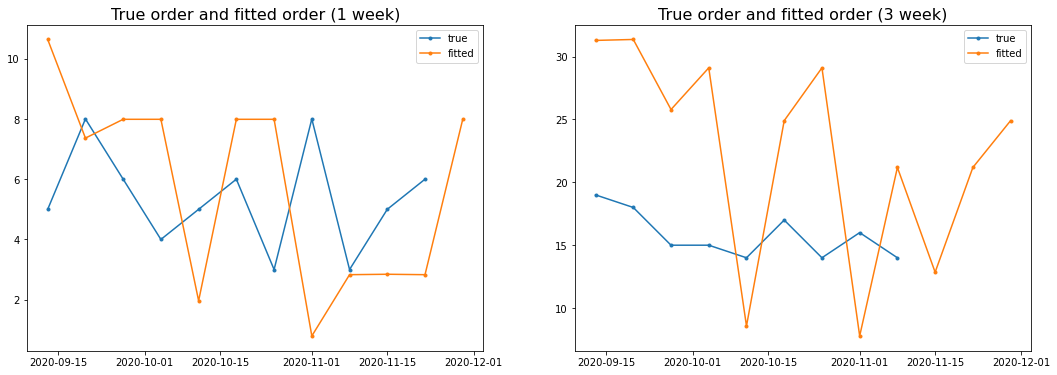

In [28]:
res_B = xgb_forecast(df_B)

we will have : 
 21.159410 orders for the next week, 
 71.293129 orders for the following 3 weeks 

rmse for next week: 11.485688 

rmse for next 3 weeks: 23.081937 

mae for next week: 8.409896 

mae for next 3 weeks: 19.345424 



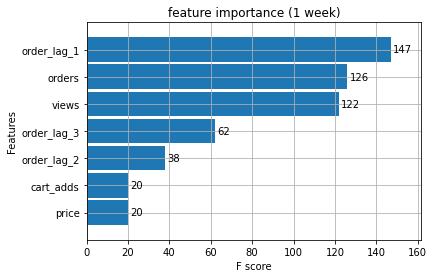

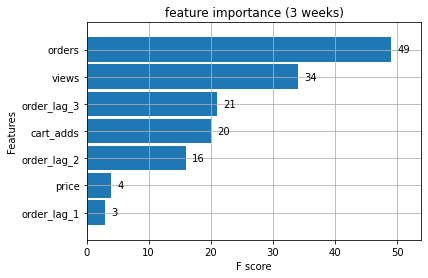

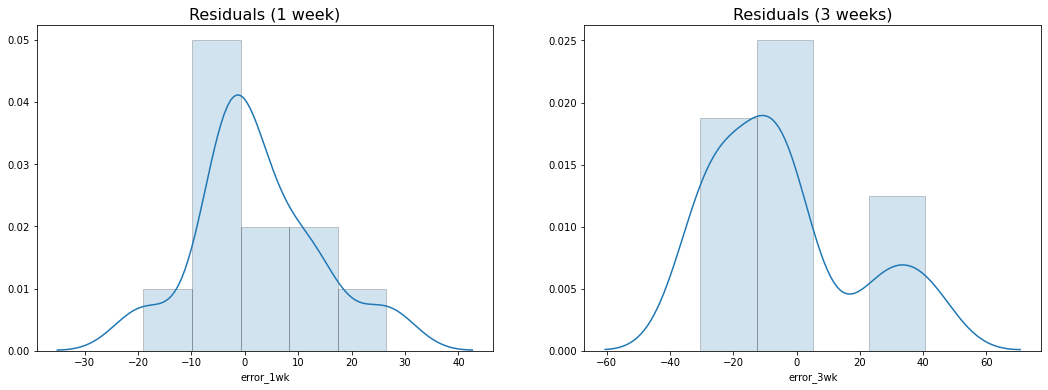

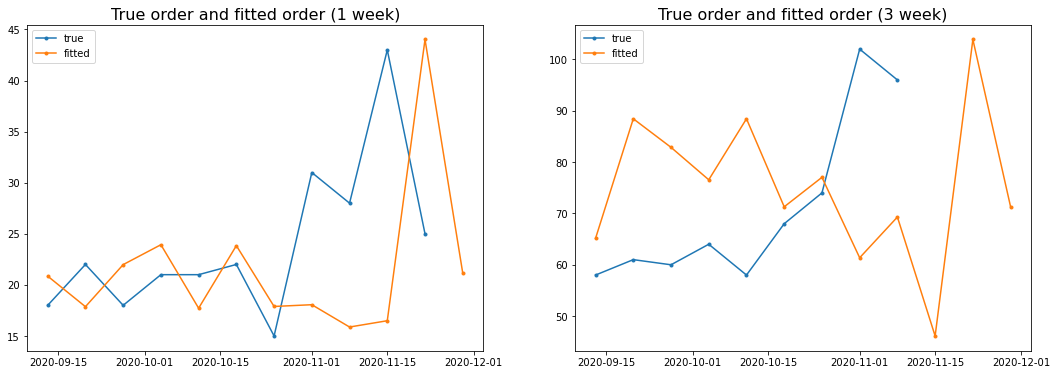

In [29]:
res_C = xgb_forecast(df_C)

we will have : 
 35.900097 orders for the next week, 
 108.733948 orders for the following 3 weeks 

rmse for next week: 9.714142 

rmse for next 3 weeks: 29.919265 

mae for next week: 7.926714 

mae for next 3 weeks: 22.525725 



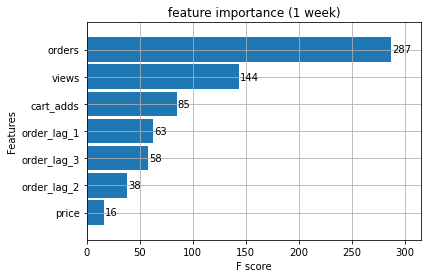

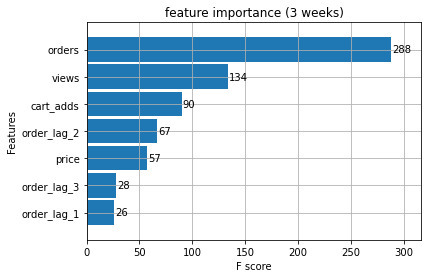

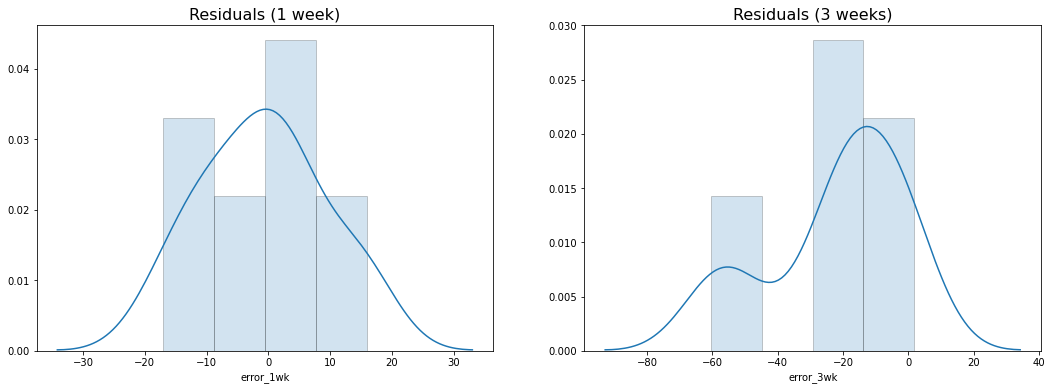

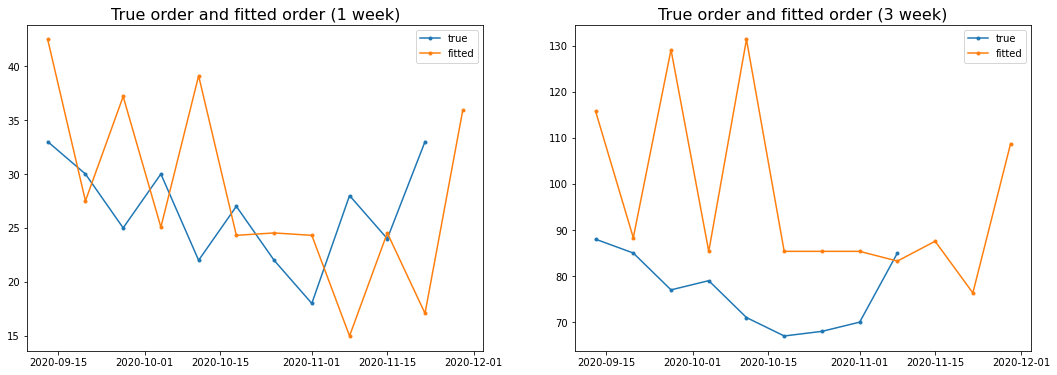

In [30]:
res_D = xgb_forecast(df_D)

we will have : 
 12.236063 orders for the next week, 
 44.539642 orders for the following 3 weeks 

rmse for next week: 4.392265 

rmse for next 3 weeks: 9.079818 

mae for next week: 3.113004 

mae for next 3 weeks: 6.267220 



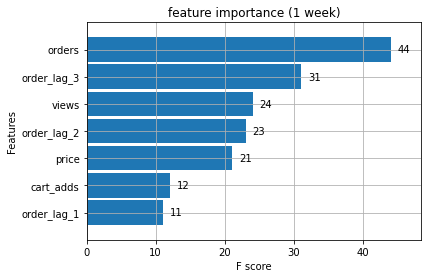

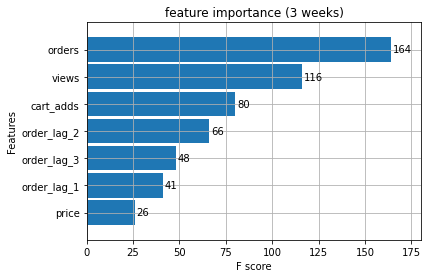

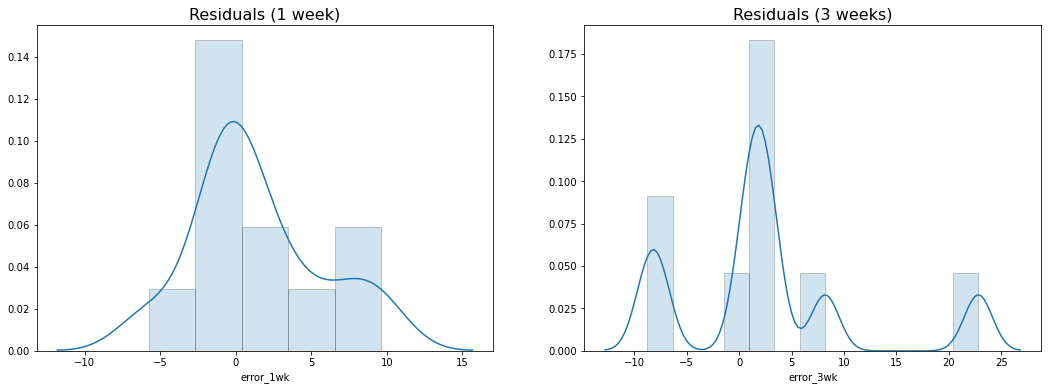

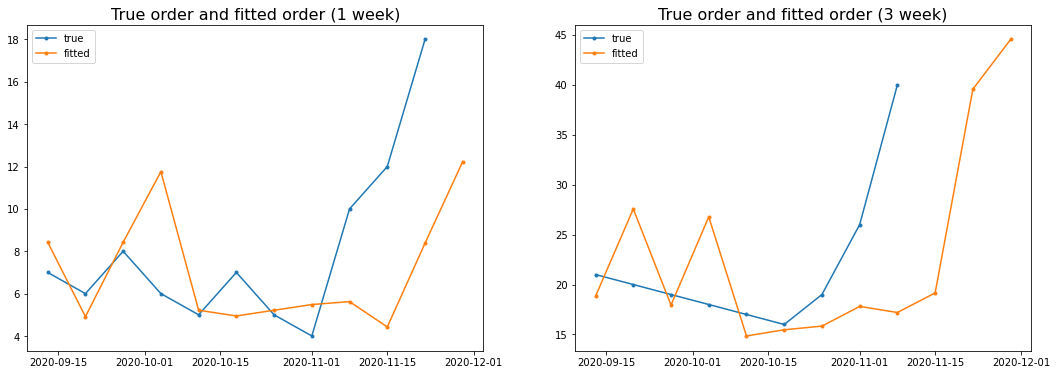

In [31]:
res_E = xgb_forecast(df_E)

## Next Steps

Now we have the pilot model and have the predictions on the demand for our key products. We 
should keep this as an baseline and try to improve the model performance by the following steps:   
1. **Add more records of data**. Now we only have data for 2020, but it will not be enough since some products might have seasonal pattern over the year (for example, product A seems to be in much higher demand in Nov. and Dec.), so we need data from other years to catch this pattern. Moreover, the year 2020 will not be a very good data set due to covid-19.
2. **Add more insightful featrues**. We can add more lags on views or price to capture some trends. Moreover, we notice product A and E are in high demand during Black Friday, so adding new featrues like "days_to_Black_Friday" might be helpful. Although "price" seems to have low feature importance, it might still be an important predictor if we present them in different ways. For example, we can add featrues like "discount" and "promotion_type" instead of merely stating "price"
3. **Fine-tune the model**. This step is skipped in this notebook but it is essential. For xgboost, we might start with tunning the n_estimators (set the early_stopping_rounds meanwhile), then we can find the optimal values for other parameters
4. **Try different models**. Although xgboost will yields satisfying results most of the time, it is also worthwhile trying other models. Deep learning models like LSTM or statistical models ARIMA are good options